In [1]:
import pandas as pd
import numpy as np
import os
os.getcwd()

'/Users/praveen/MSDS/MachineLearning/KaggleChallenges/Challenge2/Data'

In [2]:
train = pd.read_csv("./train_data_new.csv")
test = pd.read_csv("./test_data_new.csv")

/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_87978/2922911961.py:1: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./train_data_new.csv")


In [14]:
train = pd.read_csv("./train_data_new.csv")
test = pd.read_csv("./test_data_new.csv")
cat_vars = ['general_sector', 'city', 'zip_code', 'specific_sector', 'state',
       'contributor_type']
train_num_vars = ['winner_ratio', 'candidacy_count',
       'candidacy_democratic_count', 'candidacy_republican_count',
       'contribution_count', 'contribution_democratic_count',
       'contribution_republican_count', 'politician_challenger_count',
       'politician_count', 'politician_democratic_count',
       'politician_incumbency_count', 'politician_open_pos_count',
       'politician_republican_count', 'contribution_democratic_sum_2010_usd',
       'contribution_republican_sum_2010_usd', 'contribution_sum_2010_usd',
       'governor_contributions_sum_2010_usd',
       'house_and_assembly_contributions_sum_2010_usd',
       'senate_contributions_sum_2010_usd',
       'us_house_contributions_sum_2010_usd',
       'us_senate_contributions_sum_2010_usd', 'candidacy_democratic_ratio',
       'candidacy_republican_ratio', 'contribution_democratic_count_ratio',
       'contribution_republican_count_ratio', 'governor_contribution_ratio',
       'house_and_assembly_contribution_ratio', 'politician_challenger_ratio',
       'politician_democratic_ratio', 'politician_incumbency_ratio',
       'politician_open_pos_ratio', 'politician_republican_ratio',
       'senate_contribution_ratio', 'us_house_contribution_ratio',
       'us_senate_contribution_ratio', 'contrib_state_deg',
       'contrib_state_wdeg', 'contrib_state_pr', 'contrib_state_comm',
       'contrib_fed_deg', 'contrib_fed_wdeg', 'contrib_fed_pr',
       'contrib_fed_comm', 'state_all_deg', 'state_all_wdeg', 'state_all_pr',
       'state_all_comm', 'state_win_deg', 'state_win_wdeg', 'state_win_pr',
       'state_win_comm']
test_num_vars = [col for col in train_num_vars if col != "winner_ratio"]

train[train_num_vars] = train[train_num_vars].apply(pd.to_numeric, errors='coerce')
test[test_num_vars] = test[test_num_vars].apply(pd.to_numeric, errors='coerce')

# cols_with_negatives = ['contribution_democratic_sum_2010_usd','contribution_republican_sum_2010_usd','contribution_sum_2010_usd',
# 'governor_contributions_sum_2010_usd',
# 'house_and_assembly_contributions_sum_2010_usd','senate_contributions_sum_2010_usd','us_house_contributions_sum_2010_usd',
# 'us_senate_contributions_sum_2010_usd','governor_contribution_ratio','house_and_assembly_contribution_ratio','senate_contribution_ratio',
# 'us_house_contribution_ratio','us_senate_contribution_ratio']

# ### Treat these descrepent columns
# for col in cols_with_negatives:
#     train[col] = train[col].clip(lower=0)
#     test[col] = test[col].clip(lower=0)

import numpy as np

# 1) Define your ratio definitions (old_name, numerator, denominator)
ratio_defs = [
    # count‑based
    ("candidacy_democratic_ratio",   "candidacy_democratic_count",            "candidacy_count"),
    ("candidacy_republican_ratio",   "candidacy_republican_count",            "candidacy_count"),
    ("contribution_democratic_count_ratio","contribution_democratic_count","contribution_count"),
    ("contribution_republican_count_ratio","contribution_republican_count","contribution_count"),
    ("politician_challenger_ratio",  "politician_challenger_count",           "politician_count"),
    ("politician_democratic_ratio",  "politician_democratic_count",           "politician_count"),
    ("politician_incumbency_ratio",  "politician_incumbency_count",           "politician_count"),
    ("politician_open_pos_ratio",    "politician_open_pos_count",             "politician_count"),
    ("politician_republican_ratio",  "politician_republican_count",           "politician_count"),
    # dollar‑sum based
    ("governor_contribution_ratio",  "governor_contributions_sum_2010_usd",   "contribution_sum_2010_usd"),
    ("house_and_assembly_contribution_ratio","house_and_assembly_contributions_sum_2010_usd","contribution_sum_2010_usd"),
    ("senate_contribution_ratio",    "senate_contributions_sum_2010_usd",      "contribution_sum_2010_usd"),
    ("us_house_contribution_ratio",  "us_house_contributions_sum_2010_usd",    "contribution_sum_2010_usd"),
    ("us_senate_contribution_ratio", "us_senate_contributions_sum_2010_usd",   "contribution_sum_2010_usd"),
]

# 2) (Optional) Save the originals to compare later
orig_train = train[[old for old,_,_ in ratio_defs]].copy()
orig_test = test[[old for old,_,_ in ratio_defs]].copy()

# 3) Overwrite each ratio directly, safely
for oldcol, num, den in ratio_defs:
    train[oldcol] = (
        train[num]
            .div(train[den].replace({0: np.nan}))  # 0→NaN
            .fillna(0)                             # NaN→0
            .clip(0, 1)                            # clamp into [0,1]
    )
    test[oldcol] = (
        test[num]
            .div(test[den].replace({0: np.nan}))  # 0→NaN
            .fillna(0)                             # NaN→0
            .clip(0, 1)                            # clamp into [0,1]
    )


# 4) Print average absolute differences vs. originals
print("Average absolute difference between original and recomputed ratios for train and test data:")
for oldcol, _, _ in ratio_defs:
    if oldcol in orig_train:
        delta_train = (train[oldcol] - orig_train[oldcol]).abs().mean()
        delta_test = (test[oldcol] - orig_test[oldcol]).abs().mean()
        print(f"  {oldcol:40s} {delta_train:.5f}")
        print(f"  {oldcol:40s} {delta_test:.5f}")
        
    else:
        print(f"  {oldcol:40s} (original not present)")

# 5) Sanity‑check
assert np.isfinite(train[[old for old,_,_ in ratio_defs]]).all().all(), "Still found infinities!"
assert np.isfinite(test[[old for old,_,_ in ratio_defs]]).all().all(), "Still found infinities!"

assert ((train[[old for old,_,_ in ratio_defs]] >= 0) & (train[[old for old,_,_ in ratio_defs]] <= 1)).all().all(), "Ratios out of [0,1]!"
assert ((test[[old for old,_,_ in ratio_defs]] >= 0) & (test[[old for old,_,_ in ratio_defs]] <= 1)).all().all(), "Ratios out of [0,1]!"


print("✅ All ratios safely overwritten in place and checked.")


# 1. Check how many duplicate rows exist
num_duplicates_train = train.duplicated().sum()
num_duplicates_test = train.duplicated().sum()

print(f"🔍 Number of duplicate rows in train: {num_duplicates_train}")
print(f"🔍 Number of duplicate rows in test: {num_duplicates_test}")

# 2. Drop duplicate records
train = train.drop_duplicates()
test = test.drop_duplicates()

print(f"✅ Duplicates removed for train. New shape: {train.shape}")
print(f"✅ Duplicates removed for test. New shape: {test.shape}")

import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

# ------------------------------------------------------------
# 0.  Lists from above skew table
# ------------------------------------------------------------
money_like = [
    'contribution_republican_sum_2010_usd','governor_contributions_sum_2010_usd',
    'contribution_republican_sum_2010_usd','contribution_sum_2010_usd',
    'senate_contributions_sum_2010_usd','house_and_assembly_contributions_sum_2010_usd',
    'us_senate_contributions_sum_2010_usd','contribution_democratic_sum_2010_usd',
    'us_house_contributions_sum_2010_usd'
]

count_like = [
    'contribution_republican_count','contribution_count',
    'contribution_democratic_count','candidacy_democratic_count',
    'candidacy_republican_count','candidacy_count',
    'politician_open_pos_count','politician_republican_count',
    'politician_incumbency_count','politician_democratic_count',
    'politician_count','politician_challenger_count'
]

ratio_like = [
    'us_senate_contribution_ratio','us_house_contribution_ratio',
    'politician_challenger_ratio','senate_contribution_ratio','state_all_comm'
]

# ------------------------------------------------------------
# 1.  log1p transform for money & count cols
# ------------------------------------------------------------
for col in money_like + count_like:
    if col in train.columns:           # guard against typos / dropped cols
        train[col] = np.log1p(train[col].clip(lower=0))
        test[col]  = np.log1p(test[col].clip(lower=0))

# ------------------------------------------------------------
# 2.  Yeo‑Johnson power transform for skewed ratios
# ------------------------------------------------------------
pt = PowerTransformer(method="yeo-johnson", standardize=False)
train[ratio_like] = pt.fit_transform(train[ratio_like])
test[ratio_like]  = pt.transform(test[ratio_like])

# ------------------------------------------------------------
# 3.  Winsorise: clip any extreme 1 % tails on ALL numeric cols
# ------------------------------------------------------------
numeric_cols = train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col == "winner_ratio":
        lo, hi = np.percentile(train[col], [1, 99])
        train[col] = train[col].clip(lo, hi)
    else:
        lo, hi = np.percentile(train[col], [1, 99])
        train[col] = train[col].clip(lo, hi)
        test[col]  = test[col].clip(lo, hi)

print("✅  Skew & kurtosis treatments applied for train and test.")

import numpy as np
import pandas as pd
from category_encoders import TargetEncoder

# ------------------------------------------------------------------
# 1.  PARAMETERS
# ------------------------------------------------------------------
TOP_GENERAL   = 25
TOP_SPECIFIC  = 100
STATE_MIN     = 200          # states with <200 rows → OTHER
TE_SMOOTHING  = 10           # strength of shrinkage in TargetEncoder

cat_top_lump  = {
    "general_sector"  : (TOP_GENERAL,  "Other_Sector"),
    "specific_sector" : (TOP_SPECIFIC, "Other_Specific"),
}

# ------------------------------------------------------------------
# 2.  HELPER FUNCTIONS
# ------------------------------------------------------------------
def lump_by_top(df, col, top_n, new_label):
    top_vals = df[col].value_counts().nlargest(top_n).index
    df[col]  = df[col].where(df[col].isin(top_vals), new_label)
    return df

def lump_by_min(df, col, min_cnt, new_label):
    small = df[col].value_counts()[lambda s: s < min_cnt].index
    df[col] = df[col].where(~df[col].isin(small), new_label)
    return df

# ------------------------------------------------------------------
# 3.  APPLY LUMPING (***train and test***)
# ------------------------------------------------------------------
for col, (top_n, label) in cat_top_lump.items():
    train = lump_by_top(train, col, top_n, label)
    test  = lump_by_top(test,  col, top_n, label)   # ★ keep mapping identical

train = lump_by_min(train, "state", STATE_MIN, "OTHER")
test  = lump_by_min(test,  "state", STATE_MIN, "OTHER")

# ------------------------------------------------------------------
# 4.  TARGET ENCODING  (***fit on train, transform test***)
# ------------------------------------------------------------------
te_cols = ["general_sector", "specific_sector", "state"]
te      = TargetEncoder(cols=te_cols, smoothing=TE_SMOOTHING)

train[te_cols] = te.fit_transform(train[te_cols], train["winner_ratio"])
test[te_cols]  = te.transform(test[te_cols])            # ★ no fit here

# ------------------------------------------------------------------
# 5  FREQUENCY‑ENCODE city and zip_code  (train‑fit, test‑transform)
# ------------------------------------------------------------------
for col in ["city", "zip_code"]:
    freq = (train[col].astype(str)      # ensure consistent dtype
                    .value_counts(normalize=True))   # share of total rows

    train[f"{col}_freq"] = train[col].astype(str).map(freq).fillna(0)
    test[f"{col}_freq"]  = test[col].astype(str).map(freq).fillna(0)

# drop the raw string columns (high cardinality)
train.drop(columns=["city", "zip_code"], inplace=True)
test.drop(columns=["city",  "zip_code"], inplace=True)


# ------------------------------------------------------------------
# 6.  HANDLE THE REMAINING SMALL CATEGORICALS WITH ONE‑HOT
# ------------------------------------------------------------------
cat_small = ["contributor_type"]      # only 3 levels
train = pd.get_dummies(train, columns=cat_small, drop_first=True)
test  = pd.get_dummies(test,  columns=cat_small, drop_first=True)

# Keep column order identical in train & test after one‑hot:
missing_cols = [c for c in train.columns if c not in test.columns]
for c in missing_cols:
    print(f'{c} column is missing in test data')
    test[c] = 0
test = test[train.columns.drop("winner_ratio")]         # align

print("✅  Pre‑processing finished. Shapes:", train.shape)
print("✅  Pre‑processing finished. Shapes:",   test.shape)
   
for col in ["city", "zip_code","contributor_type"]:
    if col in cat_vars:
        cat_vars.remove(col)


/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_87978/561131997.py:1: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./train_data_new.csv")


Average absolute difference between original and recomputed ratios for train and test data:
  candidacy_democratic_ratio               0.00000
  candidacy_democratic_ratio               0.00000
  candidacy_republican_ratio               0.00000
  candidacy_republican_ratio               0.00000
  contribution_democratic_count_ratio      0.00000
  contribution_democratic_count_ratio      0.00000
  contribution_republican_count_ratio      0.00000
  contribution_republican_count_ratio      0.00000
  politician_challenger_ratio              0.00000
  politician_challenger_ratio              0.00000
  politician_democratic_ratio              0.00000
  politician_democratic_ratio              0.00000
  politician_incumbency_ratio              0.00000
  politician_incumbency_ratio              0.00000
  politician_open_pos_ratio                0.00000
  politician_open_pos_ratio                0.00000
  politician_republican_ratio              0.00000
  politician_republican_ratio            

In [4]:
train.winner_ratio.describe()

count    170433.000000
mean          0.594329
std           0.409620
min           0.000000
25%           0.000000
50%           0.666667
75%           1.000000
max           1.000000
Name: winner_ratio, dtype: float64

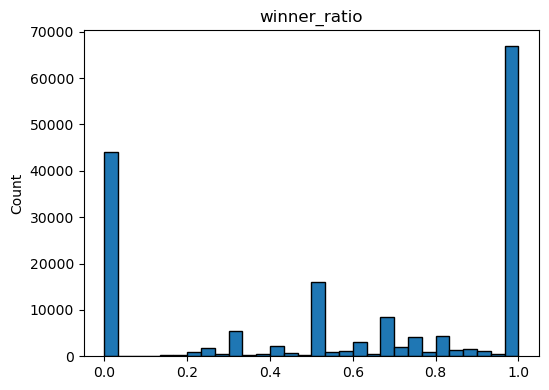

In [5]:
import matplotlib.pyplot as plt

def plot_histograms(df, num_vars, bins=30, cols=3, figsize=(15, 4)):
    n = len(num_vars)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()
    
    for ax, col in zip(axes, num_vars):
        ax.hist(df[col].dropna(), bins=bins, edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Count')
    
    # remove any unused subplots
    for ax in axes[n:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
plot_histograms(train, ['winner_ratio'])


In [6]:
import numpy as np
import pandas as pd
from scipy.special import expit  # this is the sigmoid function

# Assume 'winner_ratio' column exists in your DataFrame
winner_ratio_raw = train['winner_ratio'].values

# 1. Log(1 + winner_ratio)
log_transformed = np.log1p(winner_ratio_raw)

# 2. Sigmoid activation
sigmoid_scaled = expit(log_transformed)

# 3. Final transformed value
log_sigmoid_product = log_transformed * sigmoid_scaled

# Store it in your DataFrame if you like
train['log_sigmoid_wr'] = log_sigmoid_product

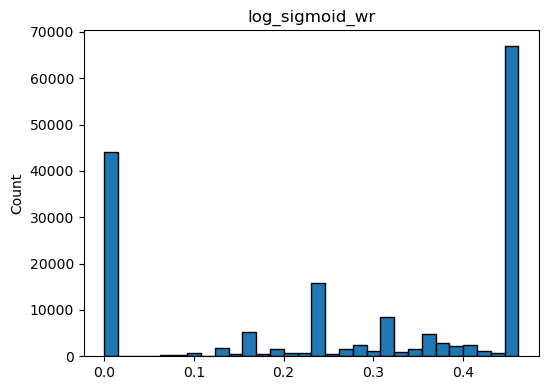

In [7]:
plot_histograms(train, ['log_sigmoid_wr'])


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

# ── 1) FEATURES & TARGET ──────────────────────────────────────────────────────
FEATURES = [
    'politician_incumbency_ratio',
    'politician_incumbency_count',
    'politician_challenger_ratio',
    'politician_open_pos_ratio',
    'politician_challenger_count',
    'politician_open_pos_count',
    'governor_contribution_ratio',
    'contribution_sum_2010_usd',
    'candidacy_count',
    'house_and_assembly_contributions_sum_2010_usd',
    'senate_contributions_sum_2010_usd',
    'senate_contribution_ratio',
    'governor_contributions_sum_2010_usd',
    'house_and_assembly_contribution_ratio',
    'politician_count',
    'candidacy_republican_count',
    'politician_republican_count',
    'contribution_republican_count',
    'contribution_count',
    'contribution_republican_sum_2010_usd'
]

training_data = train[FEATURES]
train_y      = train["winner_ratio"]    # **raw** winner_ratio in [0,1]
test_data = test[FEATURES]




In [11]:
# ✅ Necessary imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# ✅ Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': range(1, 50, 5),
    'max_depth': range(1, 30, 5),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# ✅ Initialize model
model3 = RandomForestRegressor()

# ✅ Set up GridSearchCV
rf_optimized = GridSearchCV(
    estimator=model3,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',  # optional: to ensure consistency in metric
    verbose=1
)

# ✅ Fit the model
rf_optimized.fit(training_data, train_y)

# ✅ Predict and evaluate
y_pred = rf_optimized.predict(training_data)
print("Training MSE:", metrics.mean_squared_error(train_y, y_pred))


Fitting 3 folds for each of 900 candidates, totalling 2700 fits


KeyboardInterrupt: 

Train MSE: 0.06028522318995205
Validation MSE: 0.10006120020044282


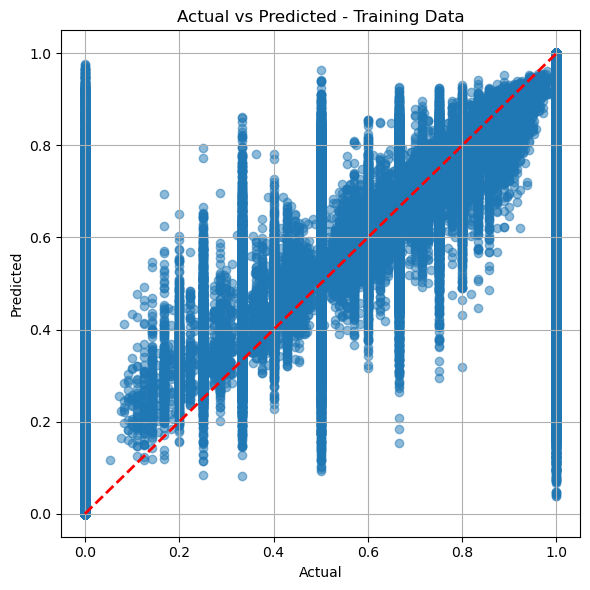

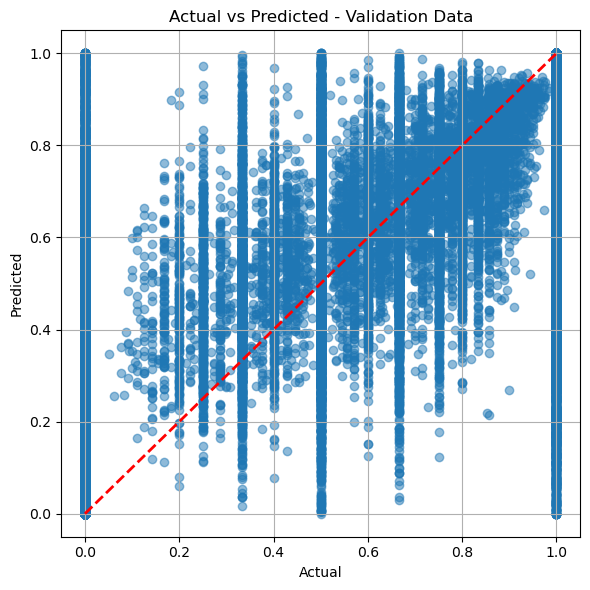

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# ✅ Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(training_data, train_y, test_size=0.25, random_state=42)

# ✅ Initialize Random Forest with fixed parameters
rf_model = RandomForestRegressor(
    n_estimators=45,
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# ✅ Fit model
rf_model.fit(X_train, y_train)

# ✅ Predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# ✅ Evaluation
print("Train MSE:", metrics.mean_squared_error(y_train, y_train_pred))
print("Validation MSE:", metrics.mean_squared_error(y_val, y_val_pred))

# ✅ Plot actual vs predicted
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_train, y_train_pred, "Actual vs Predicted - Training Data")
plot_actual_vs_predicted(y_val, y_val_pred, "Actual vs Predicted - Validation Data")


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

# ✅ Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(training_data, train_y, test_size=0.25, random_state=42)

# ✅ Hyperparameter grid
param_grid = {
    'n_estimators': range(1, 50, 5),
    'max_depth': range(1, 30, 5),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# ✅ Model and GridSearch
model3 = RandomForestRegressor(random_state=42)
rf_optimized = GridSearchCV(
    estimator=model3,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

# ✅ Fit on training data
rf_optimized.fit(X_train, y_train)

# ✅ Predict
y_train_pred = rf_optimized.predict(X_train)
y_val_pred = rf_optimized.predict(X_val)

# ✅ Evaluate
print("Train MSE:", metrics.mean_squared_error(y_train, y_train_pred))
print("Validation MSE:", metrics.mean_squared_error(y_val, y_val_pred))

# ✅ Plot actual vs. predicted
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_train, y_train_pred, "Actual vs Predicted - Training Data")
plot_actual_vs_predicted(y_val, y_val_pred, "Actual vs Predicted - Validation Data")


Fitting 3 folds for each of 900 candidates, totalling 2700 fits


KeyboardInterrupt: 